In [11]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, box
import matplotlib.pyplot as plt
import requests
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time
import pandas as pd
from nltk import edit_distance
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets
from src.models import ModelManager, load_word2vec_model
from src.analogy_tests import (
    run_analogy_test_suite,
    print_test_summary,
    test_analogy,
    explore_nearest_neighbors,
    calculate_vector_arithmetic
)

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
manager = ModelManager()
model = manager.load_word2vec_google_news()

Loading Word2Vec Google News model...
Model: word2vec-google-news-300
Size: ~1.6GB download, ~3.5GB in memory
This may take a few minutes on first download...
✓ Model loaded successfully!
  Vocabulary size: 3,000,000 words
  Vector dimensions: 300


In [3]:
def analogy_calc(lis):
    """
    lis is a list of lists
    each list in lis is of the form word1, word2, word3, target1, target2 (eg Lyon, French, Belfast, British, Irish)
    it does the vector calculation
    """
    try:
        res_li = []
        for li in lis:
            try:
                word1, word2, word3, target1, target2 = li
                positive = [word2, word3]
                negative = [word1]
                res = calculate_vector_arithmetic(model, positive, negative, topn=1000)
                
                res = pd.DataFrame(res, columns=['word', 'similarity']).reset_index()

                res['word'] = res['word'].str.lower()

                res['edit_distance_target1'] = res['word'].apply(lambda el: edit_distance(el, target1.lower()))
                res['edit_distance_target2'] = res['word'].apply(lambda el: edit_distance(el, target2.lower()))
                # print(res)
                target1_similarity = res[res['edit_distance_target1'] <= 1].set_index('word')['similarity'].max()
                target2_similarity = res[res['edit_distance_target2'] <= 1].set_index('word')['similarity'].max()

                target1_index = res[res['edit_distance_target1'] <= 1].set_index('word')['index'].min()
                target2_index = res[res['edit_distance_target2'] <= 1].set_index('word')['index'].min()
                res_li.append({
                    'list': li,
                    f'{target1}_similarity' : target1_similarity,
                    f'{target2}_similarity' : target2_similarity,
                    f'{target1}_rank' : target1_index,
                    f'{target2}_rank' : target2_index
                })
            except Exception:
                continue
        return res_li
        
    except Exception as e:
        print(f"\nError: {e}")
        import traceback
        traceback.print_exc()
        return 1

In [4]:
# don't need to run this, geographic data is saved to csv (see next cell)

# # Step 1: Download table from Wikipedia (with user-agent)
# url = "https://en.wikipedia.org/wiki/List_of_settlements_on_the_island_of_Ireland_by_population"
# headers = {"User-Agent": "Mozilla/5.0 (compatible; IrishTownsMapper/1.0; +https://example.com/contact)"}
# r = requests.get(url, headers=headers)
# r.raise_for_status()

# # Step 2: Read table and take top 50
# tables = pd.read_html(r.text)
# df = tables[0].head(50)

# # Clean up column names (optional)
# df.columns = [c.strip() for c in df.columns]

# # Step 3: Set up geocoder
# geolocator = Nominatim(user_agent="IrishTownsMapper/1.0")
# geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)  # be polite!

# # Step 4: Get lat/long for each town
# lats, longs = [], []

# for place in df["Settlement"]:
#     try:
#         location = geocode(f"{place}, Ireland")
#         if location is None:
#             location = geocode(f"{place}, Northern Ireland")
#         if location:
#             lats.append(location.latitude)
#             longs.append(location.longitude)
#         else:
#             lats.append(None)
#             longs.append(None)
#     except Exception as e:
#         print(f"Error geocoding {place}: {e}")
#         lats.append(None)
#         longs.append(None)
#     time.sleep(1)  # extra delay for safety

# df["Latitude"] = lats
# df["Longitude"] = longs

# # Step 5: Save to CSV
# df.to_csv("top50_irish_towns_with_coords.csv", index=False)
# print("Saved top50_irish_towns_with_coords.csv ✅")


In [22]:
df = pd.read_csv("top50_irish_towns_with_coords.csv")
df = df[['Settlement', 'Jurisdiction', 'Latitude', 'Longitude']]
df

,Settlement,Jurisdiction,Latitude,Longitude
0,Dublin,Republic,53.349379,-6.260559
1,Belfast,Northern,54.597580,-5.927710
2,Cork,Republic,51.898514,-8.472642
3,Limerick,Republic,52.661252,-8.630124
4,Galway,Republic,53.274412,-9.049060
5,Derry,Northern,55.000000,-7.191987
6,Newtownabbey,Northern,54.677882,-5.924920
7,Bangor,Northern,54.653400,-5.668950
8,Waterford,Republic,52.261000,-7.111908
9,Lisburn,Northern,54.523370,-6.035270


In [44]:
input_for_analogy_calc = [['Lyon', 'French', el, 'Irish', 'British'] for el in df['Settlement']]

res = pd.DataFrame(analogy_calc(input_for_analogy_calc))

res['Settlement'] = res['list'].map(lambda e: e[2])



Error: Word not found in vocabulary: "Key 'Greystones-Delgany' not present in vocabulary"
Error: Word not found in vocabulary: "Key 'Laytown–Bettystown–Mornington–Donacarney' not present in vocabulary"


In [45]:
res = pd.merge(df, res, on='Settlement')
res.head()

res = res.dropna()

abs_diffs = np.abs(res['Irish_similarity'] - res['British_similarity'])
std = np.std(abs_diffs)

res['irishness'] = (res['Irish_similarity'] - res['British_similarity']) / std

In [46]:
res

,Settlement,Jurisdiction,Latitude,Longitude,list,Irish_similarity,British_similarity,Irish_rank,British_rank,irishness
0,Dublin,Republic,53.349379,-6.260559,"[Lyon, French, Dublin, Irish, British]",0.655825,0.512567,0.0,2.0,2.632061
1,Belfast,Northern,54.597580,-5.927710,"[Lyon, French, Belfast, Irish, British]",0.575745,0.568508,0.0,1.0,0.132963
2,Cork,Republic,51.898514,-8.472642,"[Lyon, French, Cork, Irish, British]",0.637087,0.465244,0.0,36.0,3.157243
3,Limerick,Republic,52.661252,-8.630124,"[Lyon, French, Limerick, Irish, British]",0.635086,0.413726,0.0,236.0,4.067020
4,Galway,Republic,53.274412,-9.049060,"[Lyon, French, Galway, Irish, British]",0.632031,0.427482,0.0,239.0,3.758137
5,Derry,Northern,55.000000,-7.191987,"[Lyon, French, Derry, Irish, British]",0.612516,0.466418,0.0,17.0,2.684225
6,Newtownabbey,Northern,54.677882,-5.924920,"[Lyon, French, Newtownabbey, Irish, British]",0.445092,0.477187,34.0,9.0,-0.589683
7,Bangor,Northern,54.653400,-5.668950,"[Lyon, French, Bangor, Irish, British]",0.392800,0.443844,35.0,4.0,-0.937830
8,Waterford,Republic,52.261000,-7.111908,"[Lyon, French, Waterford, Irish, British]",0.581880,0.388779,0.0,169.0,3.547821
9,Lisburn,Northern,54.523370,-6.035270,"[Lyon, French, Lisburn, Irish, British]",0.489508,0.530877,10.0,2.0,-0.760073


In [47]:
gadm_uk = gpd.read_file("https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_GBR_shp.zip")
gadm_ie = gpd.read_file("https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_IRL_shp.zip")

british_isles = gpd.GeoDataFrame(pd.concat([gadm_uk, gadm_ie], ignore_index=True))

bounds = box(-11, 49.5, -5, 60)
british_isles = british_isles.clip(bounds)

/Users/daxmavy/oxford/fsds25-analogy/.venv/lib/python3.13/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'gadm41_GBR_shp.zip': 'gadm41_GBR_0' (default), 'gadm41_GBR_1', 'gadm41_GBR_2', 'gadm41_GBR_3', 'gadm41_GBR_4'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/daxmavy/oxford/fsds25-analogy/.venv/lib/python3.13/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'gadm41_IRL_shp.zip': 'gadm41_IRL_0' (default), 'gadm41_IRL_1', 'gadm41_IRL_2'. Specify layer parameter to avoid this warning.
  result = read_func(


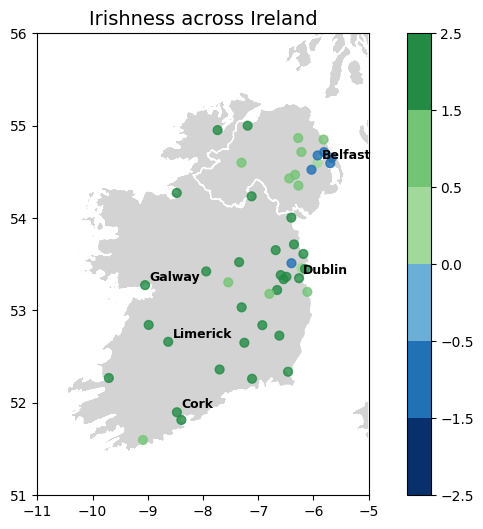

In [48]:
# Create geometry from coordinates
geometry = [Point(xy) for xy in zip(res['Longitude'], res['Latitude'])]
gdf = gpd.GeoDataFrame(res, geometry=geometry, crs="EPSG:4326")

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))
british_isles.plot(ax=ax, color="lightgrey", edgecolor="white")

bounds = [-2.5, -1.5, -0.5,0, 0.5, 1.5, 2.5]
colors = [
    "#08306B",  # dark blue (very British)
    "#2171B5",  # medium blue
    "#6BAED6",  # light blue
    "#A1D99B",  # light yellow-green (transition zone around 0)
    "#74C476",  # medium green
    "#238B45"   # dark green (very Irish)
]

cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N, clip=True)

# Points colored by 'irishness'
gdf.plot(
    ax=ax,
    column="irishness",
    cmap=cmap,
    norm=norm,
    legend=True,
    markersize=40,
    alpha=0.8
)

ax.set_xlim([-11, -5])
ax.set_ylim([51, 56])
ax.set_title("Irishness across Ireland", fontsize=14)

# --- Annotate top 5 towns ---
for i, row in gdf.head(5).iterrows():
    ax.annotate(
        text=row["Settlement"],         # column containing town name
        xy=(row["Longitude"], row["Latitude"]),
        xytext=(3, 3),                  # small offset in points
        textcoords="offset points",
        fontsize=9,
        fontweight="bold",
        color="black"
        # path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=2, foreground="white")]
    )

plt.show()


In [49]:
res.sort_values('irishness', ascending=True).head(10)

,Settlement,Jurisdiction,Latitude,Longitude,list,Irish_similarity,British_similarity,Irish_rank,British_rank,irishness
7,Bangor,Northern,54.653400,-5.668950,"[Lyon, French, Bangor, Irish, British]",0.392800,0.443844,35.0,4.0,-0.937830
16,Newtownards,Northern,54.593378,-5.696093,"[Lyon, French, Newtownards, Irish, British]",0.438600,0.487151,23.0,5.0,-0.892036
48,Ashbourne,Republic,53.511615,-6.398174,"[Lyon, French, Ashbourne, Irish, British]",0.415465,0.461091,187.0,22.0,-0.838266
9,Lisburn,Northern,54.523370,-6.035270,"[Lyon, French, Lisburn, Irish, British]",0.489508,0.530877,10.0,2.0,-0.760073
18,Carrickfergus,Northern,54.713617,-5.807311,"[Lyon, French, Carrickfergus, Irish, British]",0.470452,0.503563,10.0,2.0,-0.608353
6,Newtownabbey,Northern,54.677882,-5.924920,"[Lyon, French, Newtownabbey, Irish, British]",0.445092,0.477187,34.0,9.0,-0.589683
1,Belfast,Northern,54.597580,-5.927710,"[Lyon, French, Belfast, Irish, British]",0.575745,0.568508,0.0,1.0,0.132963
12,Swords,Republic,53.459480,-6.219175,"[Lyon, French, Swords, Irish, British]",0.399129,0.372270,4.0,6.0,0.493470
15,Ballymena,Northern,54.866297,-6.276016,"[Lyon, French, Ballymena, Irish, British]",0.550767,0.517615,0.0,7.0,0.609101
27,Newbridge,Republic,53.180149,-6.798193,"[Lyon, French, Newbridge, Irish, British]",0.424077,0.385234,0.0,3.0,0.713669


In [50]:
res[res['Jurisdiction'] == 'Republic'].sort_values('irishness', ascending=True).head(5)

,Settlement,Jurisdiction,Latitude,Longitude,list,Irish_similarity,British_similarity,Irish_rank,British_rank,irishness
48,Ashbourne,Republic,53.511615,-6.398174,"[Lyon, French, Ashbourne, Irish, British]",0.415465,0.461091,187.0,22.0,-0.838266
12,Swords,Republic,53.459480,-6.219175,"[Lyon, French, Swords, Irish, British]",0.399129,0.372270,4.0,6.0,0.493470
27,Newbridge,Republic,53.180149,-6.798193,"[Lyon, French, Newbridge, Irish, British]",0.424077,0.385234,0.0,3.0,0.713669
14,Bray,Republic,53.201460,-6.110505,"[Lyon, French, Bray, Irish, British]",0.440763,0.387724,0.0,2.0,0.974477
40,Malahide,Republic,53.450840,-6.153670,"[Lyon, French, Malahide, Irish, British]",0.542021,0.454585,0.0,16.0,1.606447


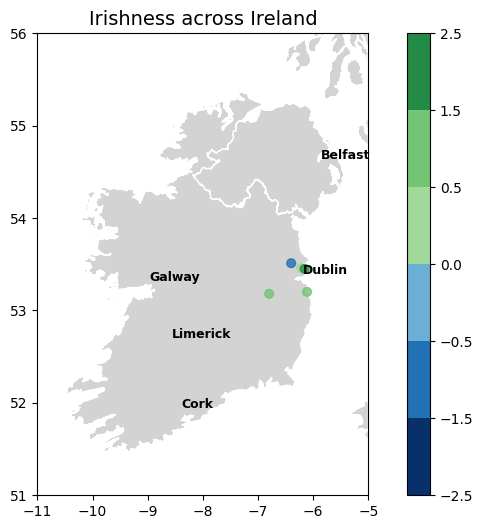

In [51]:
odd_ireland_results = res[res['Jurisdiction'] == 'Republic'].sort_values('irishness', ascending=True).head(5)['Settlement'].to_list()
odd_ireland_results

# Create geometry from coordinates
geometry = [Point(xy) for xy in zip(res['Longitude'], res['Latitude'])]
gdf = gpd.GeoDataFrame(res, geometry=geometry, crs="EPSG:4326")

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))
british_isles.plot(ax=ax, color="lightgrey", edgecolor="white")

bounds = [-2.5, -1.5, -0.5,0, 0.5, 1.5, 2.5]
colors = [
    "#08306B",  # dark blue (very British)
    "#2171B5",  # medium blue
    "#6BAED6",  # light blue
    "#A1D99B",  # light yellow-green (transition zone around 0)
    "#74C476",  # medium green
    "#238B45"   # dark green (very Irish)
]

cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N, clip=True)

# Points colored by 'irishness'
gdf[gdf['Settlement'].isin(odd_ireland_results)].plot(
    ax=ax,
    column="irishness",
    cmap=cmap,
    norm=norm,
    legend=True,
    markersize=40,
    alpha=0.8
)

ax.set_xlim([-11, -5])
ax.set_ylim([51, 56])
ax.set_title("Irishness across Ireland", fontsize=14)

# --- Annotate top 5 towns ---
for i, row in gdf.head(5).iterrows():
    ax.annotate(
        text=row["Settlement"],         # column containing town name
        xy=(row["Longitude"], row["Latitude"]),
        xytext=(3, 3),                  # small offset in points
        textcoords="offset points",
        fontsize=9,
        fontweight="bold",
        color="black"
        # path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=2, foreground="white")]
    )

plt.show()


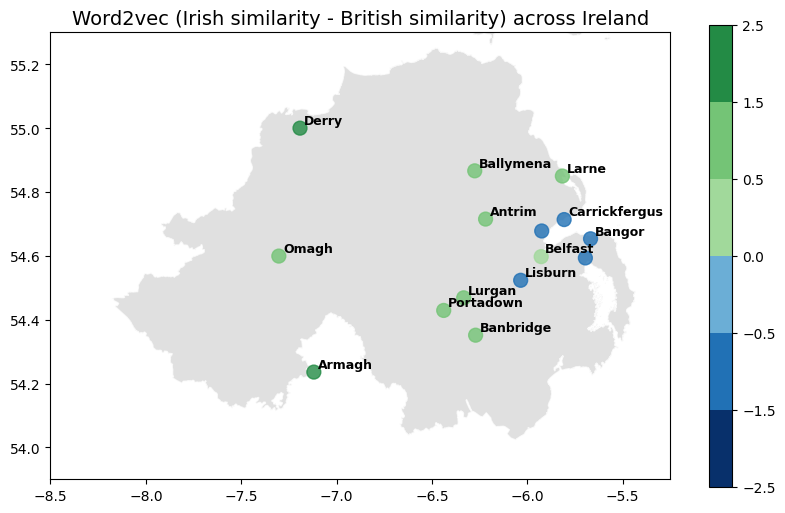

In [52]:


# Create geometry from coordinates
ni_res = res[res['Jurisdiction'] == 'Northern']

geometry = [Point(xy) for xy in zip(ni_res['Longitude'], ni_res['Latitude'])]
gdf = gpd.GeoDataFrame(ni_res, geometry=geometry, crs="EPSG:4326")

bounds = [-2.5, -1.5, -0.5,0, 0.5, 1.5, 2.5]
colors = [
    "#08306B",  # dark blue (very British)
    "#2171B5",  # medium blue
    "#6BAED6",  # light blue
    "#A1D99B",  # light yellow-green (transition zone around 0)
    "#74C476",  # medium green
    "#238B45"   # dark green (very Irish)
]

cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N, clip=True)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))
gadm_uk.plot(ax=ax, color="lightgrey", edgecolor="white", alpha=0.7)

# Points colored by 'irishness' — blue (British) to green (Irish)
gdf.plot(
    ax=ax,
    column="irishness",
    # cmap="winter",       # blue → green
    legend=True,
    markersize=100,
    alpha=0.8,
    cmap=cmap,
    norm=norm
)

ax.set_xlim([-8.5, -5.25])
ax.set_ylim([53.9, 55.3])
ax.set_title("Word2vec (Irish similarity - British similarity) across Ireland", fontsize=14)

# --- Annotate top 5 towns ---
for i, row in gdf[gdf['Jurisdiction'] == 'Northern'].iterrows():
    if row['Settlement'] not in ('Newtownards', 'Newtownabbey'):
        ax.annotate(
            text=row["Settlement"],
            xy=(row["Longitude"], row["Latitude"]),
            xytext=(3, 3),
            textcoords="offset points",
            fontsize=9,
            fontweight="bold",
            color="black"
        )

plt.show()


In [53]:
import seaborn as sns

In [54]:
gdf['sigmoid_irish'] = np.exp(gdf['Irish_similarity']) / (np.exp(gdf['Irish_similarity']) + np.exp(gdf['British_similarity']))
gdf

,Settlement,Jurisdiction,Latitude,Longitude,list,Irish_similarity,British_similarity,Irish_rank,British_rank,irishness,geometry,sigmoid_irish
1,Belfast,Northern,54.597580,-5.927710,"[Lyon, French, Belfast, Irish, British]",0.575745,0.568508,0.0,1.0,0.132963,POINT (-5.92771 54.59758),0.501809
5,Derry,Northern,55.000000,-7.191987,"[Lyon, French, Derry, Irish, British]",0.612516,0.466418,0.0,17.0,2.684225,POINT (-7.19199 55),0.536459
6,Newtownabbey,Northern,54.677882,-5.924920,"[Lyon, French, Newtownabbey, Irish, British]",0.445092,0.477187,34.0,9.0,-0.589683,POINT (-5.92492 54.67788),0.491977
7,Bangor,Northern,54.653400,-5.668950,"[Lyon, French, Bangor, Irish, British]",0.392800,0.443844,35.0,4.0,-0.937830,POINT (-5.66895 54.6534),0.487242
9,Lisburn,Northern,54.523370,-6.035270,"[Lyon, French, Lisburn, Irish, British]",0.489508,0.530877,10.0,2.0,-0.760073,POINT (-6.03527 54.52337),0.489659
15,Ballymena,Northern,54.866297,-6.276016,"[Lyon, French, Ballymena, Irish, British]",0.550767,0.517615,0.0,7.0,0.609101,POINT (-6.27602 54.8663),0.508287
16,Newtownards,Northern,54.593378,-5.696093,"[Lyon, French, Newtownards, Irish, British]",0.438600,0.487151,23.0,5.0,-0.892036,POINT (-5.69609 54.59338),0.487864
17,Lurgan,Northern,54.468441,-6.333961,"[Lyon, French, Lurgan, Irish, British]",0.526816,0.464737,1.0,14.0,1.140569,POINT (-6.33396 54.46844),0.515515
18,Carrickfergus,Northern,54.713617,-5.807311,"[Lyon, French, Carrickfergus, Irish, British]",0.470452,0.503563,10.0,2.0,-0.608353,POINT (-5.80731 54.71362),0.491723
20,Newry,Northern,52.727497,-6.617517,"[Lyon, French, Newry, Irish, British]",0.546885,0.458071,0.0,20.0,1.631769,POINT (-6.61752 52.7275),0.522189


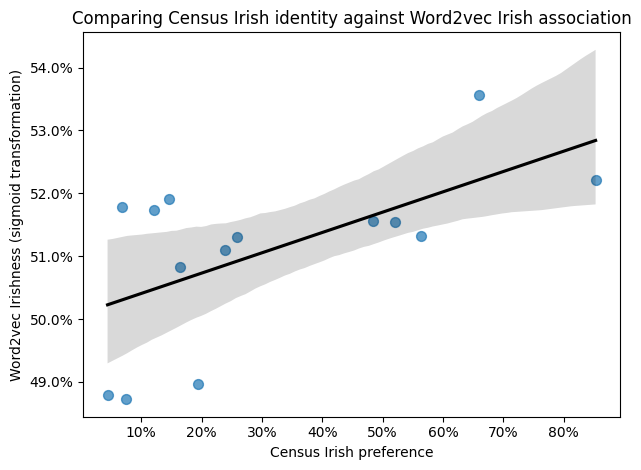

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import PercentFormatter

comp_data = pd.merge(
    left=gdf,
    right=pd.read_csv('matching_data.csv'),
    left_on='Settlement',
    right_on='Matching name'
)

comp_data['actual_irish_preference'] = comp_data['Irish preference'].str.rstrip('%').astype(float) / 100

# Create scatter plot with regression line
sns.regplot(
    data=comp_data,
    x='actual_irish_preference',
    y='sigmoid_irish',
    scatter_kws={'s': 50, 'alpha': 0.7},
    line_kws={'color': 'black'},
)

# Add % formatting to both axes
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))  # 1 = values are fractions (0–1)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# Labels and legend
plt.xlabel('Census Irish preference')
plt.ylabel('Word2vec Irishness (sigmoid transformation)')
plt.title('Comparing Census Irish identity against Word2vec Irish association')
# plt.legend(['Regression line'])
plt.tight_layout()
plt.show()


In [56]:
gdf[gdf['Jurisdiction']=='Northern']

,Settlement,Jurisdiction,Latitude,Longitude,list,Irish_similarity,British_similarity,Irish_rank,British_rank,irishness,geometry,sigmoid_irish
1,Belfast,Northern,54.597580,-5.927710,"[Lyon, French, Belfast, Irish, British]",0.575745,0.568508,0.0,1.0,0.132963,POINT (-5.92771 54.59758),0.501809
5,Derry,Northern,55.000000,-7.191987,"[Lyon, French, Derry, Irish, British]",0.612516,0.466418,0.0,17.0,2.684225,POINT (-7.19199 55),0.536459
6,Newtownabbey,Northern,54.677882,-5.924920,"[Lyon, French, Newtownabbey, Irish, British]",0.445092,0.477187,34.0,9.0,-0.589683,POINT (-5.92492 54.67788),0.491977
7,Bangor,Northern,54.653400,-5.668950,"[Lyon, French, Bangor, Irish, British]",0.392800,0.443844,35.0,4.0,-0.937830,POINT (-5.66895 54.6534),0.487242
9,Lisburn,Northern,54.523370,-6.035270,"[Lyon, French, Lisburn, Irish, British]",0.489508,0.530877,10.0,2.0,-0.760073,POINT (-6.03527 54.52337),0.489659
15,Ballymena,Northern,54.866297,-6.276016,"[Lyon, French, Ballymena, Irish, British]",0.550767,0.517615,0.0,7.0,0.609101,POINT (-6.27602 54.8663),0.508287
16,Newtownards,Northern,54.593378,-5.696093,"[Lyon, French, Newtownards, Irish, British]",0.438600,0.487151,23.0,5.0,-0.892036,POINT (-5.69609 54.59338),0.487864
17,Lurgan,Northern,54.468441,-6.333961,"[Lyon, French, Lurgan, Irish, British]",0.526816,0.464737,1.0,14.0,1.140569,POINT (-6.33396 54.46844),0.515515
18,Carrickfergus,Northern,54.713617,-5.807311,"[Lyon, French, Carrickfergus, Irish, British]",0.470452,0.503563,10.0,2.0,-0.608353,POINT (-5.80731 54.71362),0.491723
20,Newry,Northern,52.727497,-6.617517,"[Lyon, French, Newry, Irish, British]",0.546885,0.458071,0.0,20.0,1.631769,POINT (-6.61752 52.7275),0.522189
